<a href="https://colab.research.google.com/github/heeyooon/TNT_2021_winter_team_3/blob/main/week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RNN을 사용한 텍스트 분류**

RNN이 처음이라,, <br>
https://www.tensorflow.org/tutorials/text/text_classification_rnn?hl=ko<br>
튜토리얼 공부해보았습니다...

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
## 훈련 결과 그래프를 plotting 하는 "plot_graphs" 함수를 미리 만들기
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## **1. Data Load**

In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', 
                          with_info=True,
                          as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteRLH3UN/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteRLH3UN/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteRLH3UN/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [4]:
## 인코더 내의 단어 개수 체크

encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [5]:
# 이 텍스트 인코더는 문자열을 가역적으로(회복 가능하게) 인코딩 :: 다시 decode 되어도 원래상태로 복구됨

sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [6]:
# 필요한 경우에는 바이트로 인코딩됨

assert original_string == sample_string

for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [7]:
## TRAIN, TEST BATCH

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)

## 배치에서 가장 긴 문자열의 길이로 zero padding
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE)

## **2. Base Model**

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    ## Bidirectional :: RNN 레이어(여기선 LSTM) 을 통해 입력을 앞뒤로 전파하고 다음 출력을 연결
    ## -> 장거리 종속성 학습에 도움
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),  # learning rate 0.00001
              metrics=['accuracy'])

In [9]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 47s 103ms/step - loss: 0.6881 - accuracy: 0.5300 - val_loss: 0.5164 - val_accuracy: 0.7818
Epoch 2/10
391/391 [==============================] - 40s 103ms/step - loss: 0.4073 - accuracy: 0.8293 - val_loss: 0.3499 - val_accuracy: 0.8547
Epoch 3/10
391/391 [==============================] - 41s 103ms/step - loss: 0.2723 - accuracy: 0.8962 - val_loss: 0.3231 - val_accuracy: 0.8719
Epoch 4/10
391/391 [==============================] - 41s 104ms/step - loss: 0.2187 - accuracy: 0.9229 - val_loss: 0.3284 - val_accuracy: 0.8682
Epoch 5/10
391/391 [==============================] - 41s 104ms/step - loss: 0.1968 - accuracy: 0.9293 - val_loss: 0.3426 - val_accuracy: 0.8667
Epoch 6/10
391/391 [==============================] - 42s 105ms/step - loss: 0.1658 - accuracy: 0.9440 - val_loss: 0.3525 - val_accuracy: 0.8630
Epoch 7/10
391/391 [==============================] - 41s 105ms/step - loss: 0.1554 - accuracy: 0.9480 - val_loss: 0.3912 - val_ac

In [10]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 15s 39ms/step - loss: 0.4485 - accuracy: 0.8609
Test Loss: 0.4484720826148987
Test Accuracy: 0.8609200119972229


## **3. Test with Masking**

In [22]:
## 원하는 size 만큼 zero padding
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

def sample_predict(sample_pred_text, model, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  ## pad == True 일때만 padding 할 수 있도록
  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [13]:
## predict on a sample text without padding

sample_pred_text1 = ("The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.")
sample_pred_text2 = ("This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan.")

without_pad_pred = sample_predict(sample_pred_text1, model, pad = False)
print("1st Text Prediction without Padding : ", without_pad_pred[0][0])

with_pad_pred = sample_predict(sample_pred_text1, model, pad=True)
print("1st Text Prediction with Padding : ", with_pad_pred[0][0])

without_pad_pred = sample_predict(sample_pred_text2, model, pad = False)
print("2nd Text Prediction without Padding : ", without_pad_pred[0][0])

with_pad_pred = sample_predict(sample_pred_text2, model, pad=True)
print("2nd Text Prediction with Padding : ", with_pad_pred[0][0])


1st Text Prediction without Padding :  0.49946663
1st Text Prediction with Padding :  0.4003676
2nd Text Prediction without Padding :  0.333457
2nd Text Prediction with Padding :  0.333457


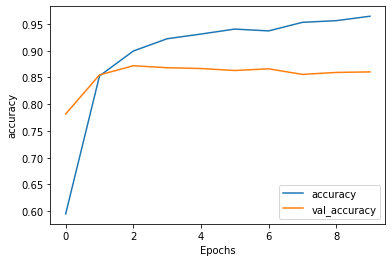

In [14]:
plot_graphs(history, 'accuracy')

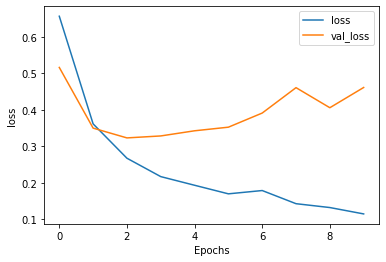

In [15]:
plot_graphs(history, 'loss')

## **4. 2 LSTM Layers**

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 105s 255ms/step - loss: 0.6880 - accuracy: 0.5238 - val_loss: 0.5392 - val_accuracy: 0.7442
Epoch 2/10
391/391 [==============================] - 102s 259ms/step - loss: 0.4226 - accuracy: 0.8273 - val_loss: 0.3540 - val_accuracy: 0.8516
Epoch 3/10
391/391 [==============================] - 102s 260ms/step - loss: 0.2806 - accuracy: 0.8980 - val_loss: 0.3532 - val_accuracy: 0.8692
Epoch 4/10
391/391 [==============================] - 105s 267ms/step - loss: 0.2243 - accuracy: 0.9232 - val_loss: 0.3483 - val_accuracy: 0.8674
Epoch 5/10
391/391 [==============================] - 104s 265ms/step - loss: 0.1784 - accuracy: 0.9450 - val_loss: 0.3767 - val_accuracy: 0.8639
Epoch 6/10
391/391 [==============================] - 103s 262ms/step - loss: 0.1576 - accuracy: 0.9531 - val_loss: 0.4113 - val_accuracy: 0.8632
Epoch 7/10
391/391 [==============================] - 104s 265ms/step - loss: 0.1318 - accuracy: 0.9637 - val_loss: 0.4350 -

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 31s 79ms/step - loss: 0.5665 - accuracy: 0.8436
Test Loss: 0.5664851069450378
Test Accuracy: 0.843559980392456


In [23]:
# predict on a sample text without padding.
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, model, pad=False)
print("Prediction without Padding : ", predictions)

predictions = sample_predict(sample_pred_text, model, pad=True)
print("Prediction with Padding : ",predictions)

Prediction without Padding :  [[0.05912523]]
Prediction with Padding :  [[0.05764305]]
